## Energy Efficient Model

### Importing dependencies

In [ ]:
import pandas as pd
import glob
import os
import numpy as np
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

### Attaching storage which contains NYISO Data

In [ ]:
# fetch data from drive
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


### Process Energy Hourly Rates Data

In [ ]:
dir_path = '/content/drive/MyDrive/energy_prices/'

# List all subdirectories in the main directory
sub_dirs = [os.path.join(dir_path, sub_dir) for sub_dir in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, sub_dir))]

# Initialize an empty list to hold DataFrames
data_frames = []

# Loop through each subdirectory and read CSV files
for sub_dir in sub_dirs:
    csv_files = glob.glob(os.path.join(sub_dir, '*.csv'))
    for file in csv_files:
        df = pd.read_csv(file)
        data_frames.append(df)

# Concatenate all DataFrames into a single DataFrame
all_data = pd.concat(data_frames, ignore_index=True)

# Convert 'Time Stamp' column to datetime
all_data['Time Stamp'] = pd.to_datetime(all_data['Time Stamp'])

# Ensure the numeric columns are converted to numeric types, coercing errors to NaN
all_data['LBMP ($/MWHr)'] = pd.to_numeric(all_data['LBMP ($/MWHr)'], errors='coerce')
all_data['Marginal Cost Losses ($/MWHr)'] = pd.to_numeric(all_data['Marginal Cost Losses ($/MWHr)'], errors='coerce')
all_data['Marginal Cost Congestion ($/MWHr)'] = pd.to_numeric(all_data['Marginal Cost Congestion ($/MWHr)'], errors='coerce')

# Get the first few rows of the combined DataFrame
print(all_data.head())


  Time Stamp    Name   PTID  LBMP ($/MWHr)  Marginal Cost Losses ($/MWHr)  \
0 2024-06-01  CAPITL  61757          21.85                           0.82   
1 2024-06-01  CENTRL  61754          21.03                           0.00   
2 2024-06-01  DUNWOD  61760          22.18                           1.16   
3 2024-06-01  GENESE  61753          20.61                          -0.42   
4 2024-06-01     H Q  61844          21.03                           0.00   

   Marginal Cost Congestion ($/MWHr)  
0                                0.0  
1                                0.0  
2                                0.0  
3                                0.0  
4                                0.0  


### Filter Energy Hourly Rates Data and Convert to Numpy Array

In [ ]:
# Filter out rows where Name is not 'N.Y.C.'
nyc_data = all_data[all_data['Name'] == 'N.Y.C.'].copy()

# Get the unique days in the dataset
unique_days = nyc_data['Time Stamp'].dt.date.unique()

# Initialize a list to store the hourly rates for each day
hourly_rates_list = []

# Loop over each day
for day in unique_days:
    # Filter data for the current day
    daily_data = nyc_data[nyc_data['Time Stamp'].dt.date == day].copy()

    # Combine the columns into a single LBMP column
    daily_data['Total LBMP ($/MWHr)'] = (
        daily_data['LBMP ($/MWHr)'] +
        daily_data['Marginal Cost Losses ($/MWHr)'] +
        daily_data['Marginal Cost Congestion ($/MWHr)']
    )

    # Drop rows with NaN values in the 'Total LBMP ($/MWHr)' column
    daily_data = daily_data.dropna(subset=['Total LBMP ($/MWHr)'])

    # Select only the 'Time Stamp' and 'Total LBMP ($/MWHr)' columns
    daily_data = daily_data[['Time Stamp', 'Total LBMP ($/MWHr)']]

    # Create a matrix for the current day's hourly rates
    hourly_rates = daily_data.set_index('Time Stamp').resample('H').mean()['Total LBMP ($/MWHr)'].values

    # Ensure the hourly rates have 24 samples, fill missing values if necessary
    if len(hourly_rates) < 24:
        hourly_rates = np.pad(hourly_rates, (0, 24 - len(hourly_rates)), 'constant', constant_values=np.nan)

    # Store the matrix in the list
    hourly_rates_list.append(hourly_rates)

# Convert the list to a NumPy array
hourly_rates = np.array(hourly_rates_list)

print(hourly_rates.shape)



(547, 24)


### Process Numpy Array

In [ ]:
# Identify NaNs in hourly_rates
nan_indices = np.where(np.isnan(hourly_rates))
print("NaN indices in hourly_rates:", nan_indices)

# Interpolate to fill NaNs in hourly_rates
hourly_rates = pd.DataFrame(hourly_rates).interpolate(axis=1).values

# Verify no NaNs in hourly_rates after interpolation
print("NaNs in hourly_rates after interpolation:", np.isnan(hourly_rates).sum())

NaN indices in hourly_rates: (array([100, 285]), array([2, 2]))
NaNs in hourly_rates after interpolation: 0


### Energy Hourly Rates plot for NYC

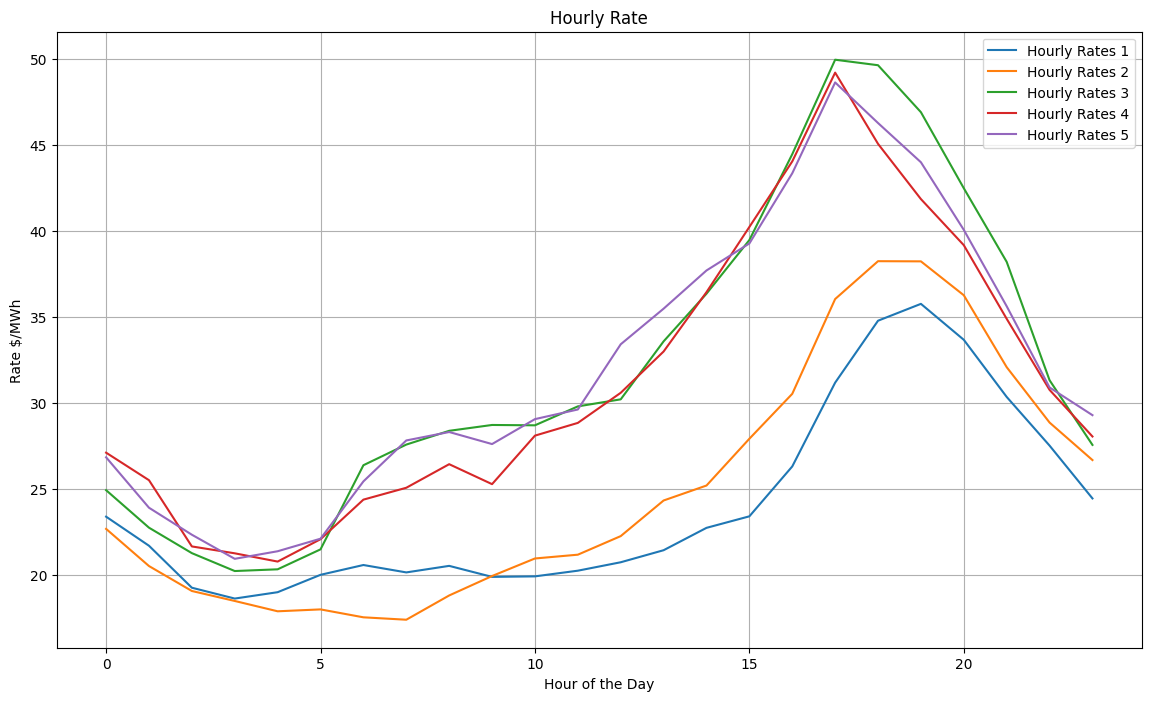

In [ ]:
# Plot a few of the hourly rates
num_profiles_to_plot = 5

plt.figure(figsize=(14, 8))
for i in range(num_profiles_to_plot):
    plt.plot(hourly_rates[i], label=f'Hourly Rates {i+1}')
plt.xlabel('Hour of the Day')
plt.ylabel('Rate $/MWh')
plt.title('Hourly Rate')
plt.legend()
plt.grid(True)
plt.show()

### Generate Training Output Data using energy rate convexity algorithm

In [ ]:
# Number of days
num_days = hourly_rates.shape[0]

# Initialize a matrix to store the charging profiles
charging_profiles = np.zeros((num_days, 24))

# Loop through each day's hourly rates
for i in range(num_days):
    i_hourly_rates = hourly_rates[i, :]

    # Random total energy required (kWh) and curtailment power
    total_energy = np.random.uniform(30, 70)  # Random energy between 10 and 100 kWh
    curtailment_power = np.random.uniform(3, 5)  # Random curtailment power between 1 and 10 kW

    # Check if total_energy can be met with the given curtailment power
    max_possible_energy = curtailment_power * len(i_hourly_rates)

    if max_possible_energy < total_energy:
        raise ValueError(f"Total energy requirement cannot be met with the given curtailment power and number of hours for day {i+1}.")

    # Create a DataFrame for easier manipulation
    df = pd.DataFrame({'Hour': range(24), 'Rate': i_hourly_rates})

    # Sort the DataFrame by the rates
    df = df.sort_values('Rate')

    # Calculate the fraction of total energy to be allocated to each hour
    df['Energy Fraction'] = (1 / df['Rate']) / (1 / df['Rate']).sum()

    # Calculate the actual energy to be allocated to each hour without curtailment
    df['Allocated Energy (kWh)'] = df['Energy Fraction'] * total_energy

    # Apply curtailment: limit the charging power to the curtailment power
    df['Curtailed Energy (kWh)'] = np.minimum(df['Allocated Energy (kWh)'], curtailment_power)

    # Calculate the total curtailed energy
    curtailed_energy = df['Allocated Energy (kWh)'].sum() - df['Curtailed Energy (kWh)'].sum()

    # Distribute the curtailed energy to non-peak hours
    non_peak_hours = df['Curtailed Energy (kWh)'] < curtailment_power
    df.loc[non_peak_hours, 'Curtailed Energy (kWh)'] += df.loc[non_peak_hours, 'Curtailed Energy (kWh)'] / df.loc[non_peak_hours, 'Curtailed Energy (kWh)'].sum() * curtailed_energy

    # Ensure total energy meets the requirement
    total_curtailed_energy = df['Curtailed Energy (kWh)'].sum()
    adjustment_factor = total_energy / total_curtailed_energy
    df['Curtailed Energy (kWh)'] *= adjustment_factor

    # Sort the DataFrame back by hour to get the charging profile in chronological order
    df = df.sort_values('Hour')

    # Get the charging profile and store it in the matrix
    charging_profiles[i, :] = df['Curtailed Energy (kWh)'].values

# Print the resulting matrix of charging profiles
print("Charging Profiles:")
print(charging_profiles)

Charging Profiles:
[[1.90066238 2.04868631 2.30822913 ... 1.46479384 1.61542489 1.81826147]
 [1.79352896 1.98232148 2.1330486  ... 1.26799367 1.40946767 1.52463406]
 [1.70156105 1.86461174 1.99435435 ... 1.11046903 1.35440348 1.53918422]
 ...
 [2.68236492 2.84863422 2.86494319 ... 2.30780973 2.30426743 2.26829045]
 [2.50663633 2.62910032 2.68811585 ... 2.86665895 2.97915573 2.88025422]
 [2.31271354 2.38709656 2.70397663 ... 4.26492483 4.52992317 4.24529664]]


### Process Output Data

In [ ]:
# Identify NaNs in real_profiles
nan_indices = np.where(np.isnan(charging_profiles))
print("NaN indices in real_profiles:", nan_indices)

# Interpolate to fill NaNs in real_profiles
real_profiles = pd.DataFrame(charging_profiles).interpolate(axis=1).values

# Verify no NaNs in real_profiles after interpolation
print("NaNs in real_profiles after interpolation:", np.isnan(charging_profiles).sum())

NaN indices in real_profiles: (array([], dtype=int64), array([], dtype=int64))
NaNs in real_profiles after interpolation: 0


### Hourly Rates and Training Energy Profiles Plot

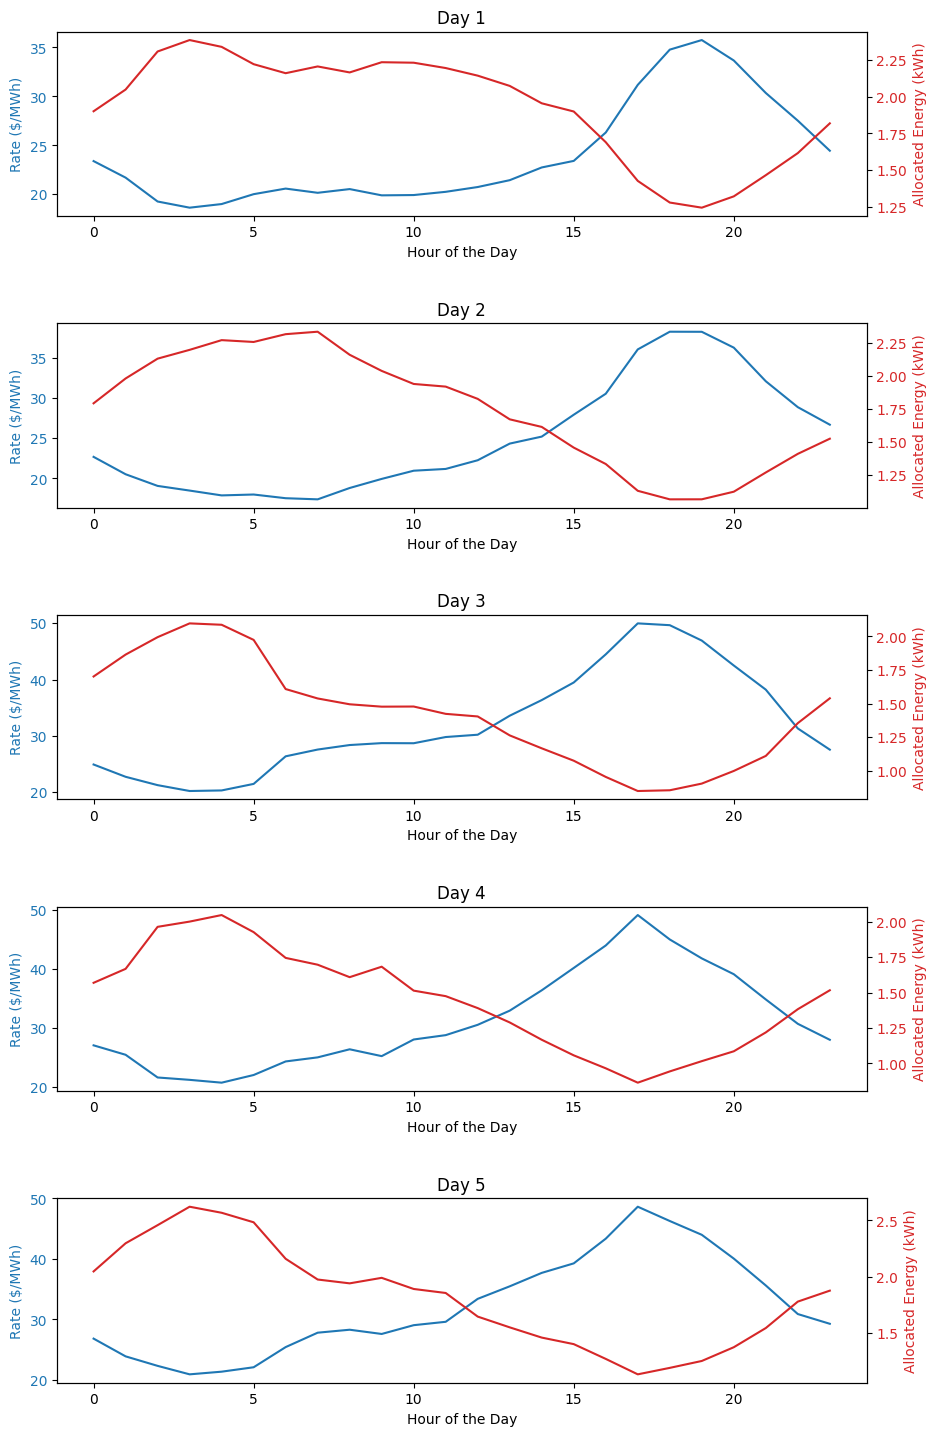

In [ ]:
# Plot a few of the charging profiles and hourly rates
days_to_plot = 5  # Number of days to plot
fig, axs = plt.subplots(days_to_plot, 1, figsize=(10, 15))

for i in range(days_to_plot):
    ax1 = axs[i]
    ax1.set_xlabel('Hour of the Day')
    ax1.set_ylabel('Rate ($/MWh)', color='tab:blue')
    ax1.plot(range(24), hourly_rates[i, :], color='tab:blue', label='Hourly Rate')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Allocated Energy (kWh)', color='tab:red')
    ax2.plot(range(24), charging_profiles[i, :], color='tab:red', label='Charging Profile')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    ax1.set_title(f'Day {i+1}')
    fig.tight_layout(pad=3.0)

plt.show()

### Data Preparation for Training Model

In [ ]:
# Training data preparation (dummy data for illustration)
batch_size = 10
num_samples = hourly_rates.shape[0]

# Training data preparation
total_energy_values = np.random.uniform(30, 70, (num_days, 1))  # Total energy between 10 and 100 kWh
curtailment_values = np.random.uniform(3, 5, (num_days, 1))  # Curtailment power between 1 and 10 kW

# Normalize input data
scaler_hourly_rates = MinMaxScaler()
scaler_total_energy = MinMaxScaler()
scaler_curtailment = MinMaxScaler()

# Fit and transform the hourly rates
hourly_rates_normalized = scaler_hourly_rates.fit_transform(hourly_rates)

# Fit and transform total energy and curtailment values
total_energy_values_normalized = scaler_total_energy.fit_transform(total_energy_values)
curtailment_values_normalized = scaler_curtailment.fit_transform(curtailment_values)

input_data_normalized = np.hstack((hourly_rates_normalized, total_energy_values_normalized, curtailment_values_normalized))

# Check for NaNs after normalization
print(np.isnan(input_data_normalized).sum())

# Real charging profiles (dummy data for illustration)
real_profiles = charging_profiles

scaler_real_profiles = MinMaxScaler()
real_profiles_normalized = scaler_real_profiles.fit_transform(real_profiles)

# Check for NaNs after normalization
print(np.isnan(real_profiles_normalized).sum())

# Print the shapes of the input data and real profiles to verify
print("Shape of input data:", input_data_normalized.shape)
print("Shape of real profiles:", real_profiles_normalized.shape)

# Save scalers
joblib.dump(scaler_hourly_rates, '/content/drive/MyDrive/energy_model/scaler_hourly_rates.pkl')
joblib.dump(scaler_total_energy, '/content/drive/MyDrive/energy_model/scaler_total_energy.pkl')
joblib.dump(scaler_curtailment, '/content/drive/MyDrive/energy_model/scaler_curtailment.pkl')
joblib.dump(scaler_real_profiles, '/content/drive/MyDrive/energy_model/scaler_real_profiles.pkl')

0
0
Shape of input data: (547, 26)
Shape of real profiles: (547, 24)


['/content/drive/MyDrive/energy_model/scaler_real_profiles.pkl']

### Model Training

Epoch 1/100
14/14 [==============================] - 7s 52ms/step - loss: 0.1547 - val_loss: 0.1371
Epoch 2/100
14/14 [==============================] - 0s 9ms/step - loss: 0.1052 - val_loss: 0.0672
Epoch 3/100
14/14 [==============================] - 0s 9ms/step - loss: 0.0526 - val_loss: 0.0312
Epoch 4/100
14/14 [==============================] - 0s 11ms/step - loss: 0.0329 - val_loss: 0.0265
Epoch 5/100
14/14 [==============================] - 0s 9ms/step - loss: 0.0290 - val_loss: 0.0251
Epoch 6/100
14/14 [==============================] - 0s 10ms/step - loss: 0.0261 - val_loss: 0.0244
Epoch 7/100
14/14 [==============================] - 0s 9ms/step - loss: 0.0246 - val_loss: 0.0241
Epoch 8/100
14/14 [==============================] - 0s 11ms/step - loss: 0.0241 - val_loss: 0.0238
Epoch 9/100
14/14 [==============================] - 0s 9ms/step - loss: 0.0241 - val_loss: 0.0236
Epoch 10/100
14/14 [==============================] - 0s 10ms/step - loss: 0.0229 - val_loss: 0.0235
Epoc

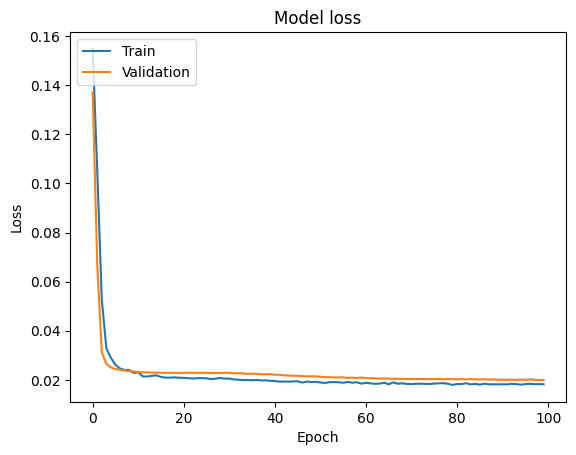

In [ ]:
# Reshape data for LSTM
X_train = input_data_normalized.reshape((input_data_normalized.shape[0], 1, input_data_normalized.shape[1]))
y_train = real_profiles_normalized

# Define the LSTM model with regularization
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(24, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model Inference

In [ ]:
# Generate a new charging profile based on input data
new_hourly_rates = np.array([22.21, 20.66, 18.35, 17.75, 18.14, 19.08, 19.66, 19.22, 19.5, 18.76, 18.65, 18.88, 19.33, 19.91, 21.15, 21.7, 24.55, 28.94, 32.43, 33.22, 31.3, 28.44, 25.68, 23.01]).reshape(1, -1)
new_total_energy = np.array([[50]])  # Random total energy between 30 and 70 kWh
new_curtailment_limit = np.array([[3]])  # Random curtailment power between 3 and 5 kW

new_hourly_rates_normalized = scaler_hourly_rates.transform(new_hourly_rates)
new_total_energy_normalized = scaler_total_energy.transform(new_total_energy)
new_curtailment_limit_normalized = scaler_curtailment.transform(new_curtailment_limit)

new_input_normalized = np.hstack((new_hourly_rates_normalized, new_total_energy_normalized, new_curtailment_limit_normalized))
new_input_reshaped = new_input_normalized.reshape((new_input_normalized.shape[0], 1, new_input_normalized.shape[1]))

# Generate the charging profile
generated_profile_normalized = model.predict(new_input_reshaped)
generated_profile = scaler_real_profiles.inverse_transform(generated_profile_normalized)

print("Generated Charging Profile:\n", generated_profile)


1/1 [==============================] - 0s 19ms/step
Generated Charging Profile:
 [[2.2151136 2.4278884 2.5570025 2.6388474 2.6065881 2.4074996 2.125495
  2.0174513 1.908136  1.9176843 1.9238529 1.9549723 1.9934498 1.9964244
  2.0390773 2.0503511 1.9470215 1.7433889 1.6044722 1.4942234 1.554036
  1.723802  1.9003501 2.012805 ]]


### Verify Model

In [ ]:
total_generated_energy = 0

for energy in generated_profile[0]:
    total_generated_energy += energy

print(f"Total generated energy: {total_generated_energy:.2f} kWh")

if np.isclose(total_generated_energy, new_total_energy[0][0]):
    print("Generated profile matches the total energy requirement.")
else:
    print("Generated profile does not match the total energy requirement.")


Total generated energy: 48.76 kWh
Generated profile does not match the total energy requirement.


### Predicted Energy Profile Plot

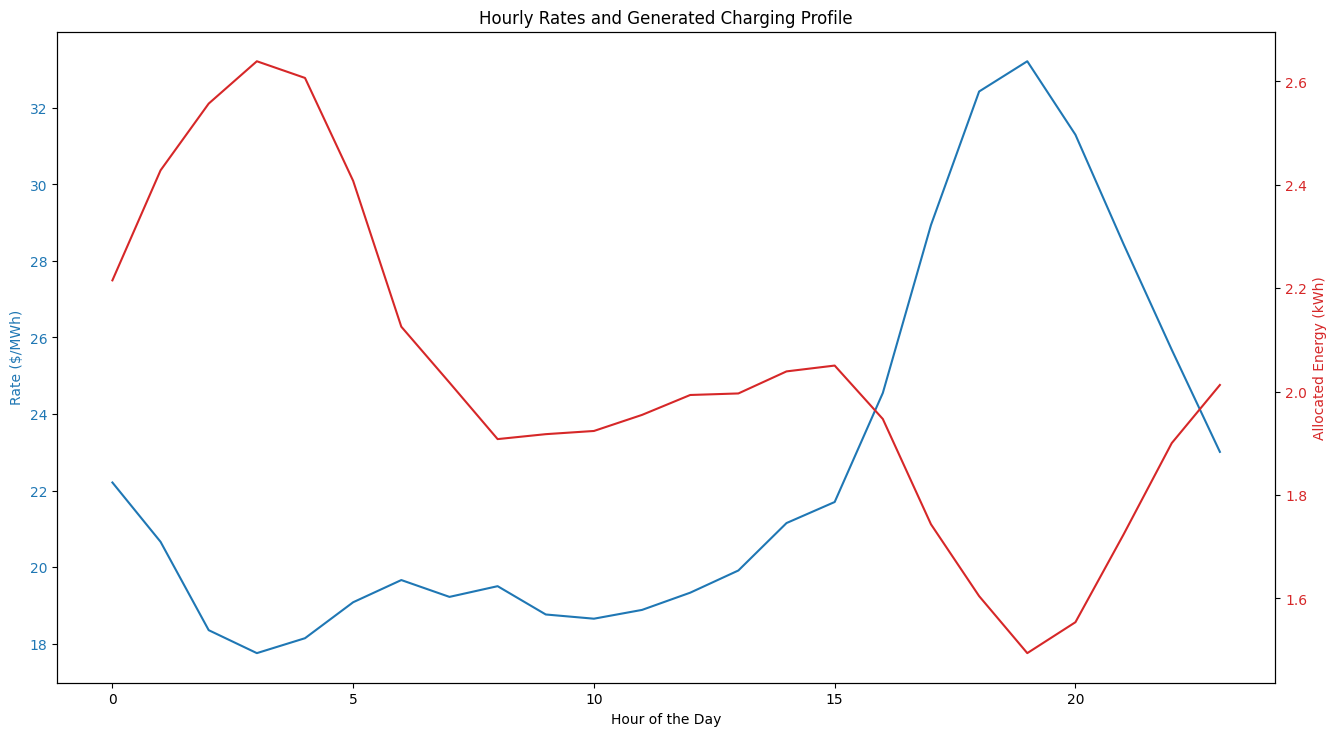

In [ ]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the hourly rates on the first axis
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Rate ($/MWh)', color='tab:blue')
ax1.plot(range(24), new_hourly_rates[0], color='tab:blue', label='Hourly Rates')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a twin Axes sharing the xaxis for the charging profile
ax2 = ax1.twinx()
ax2.set_ylabel('Allocated Energy (kWh)', color='tab:red')
ax2.plot(range(24), generated_profile[0], color='tab:red', label='Generated Profile')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a title and layout adjustments
ax1.set_title('Hourly Rates and Generated Charging Profile')
fig.tight_layout(pad=3.0)

# Show the plot
plt.show()

### Fix Predicted Energy Profile

In [ ]:
def adjust_profile_to_total_energy(profile, total_energy):
    profile_sum = profile.sum()
    if not np.isclose(profile_sum, total_energy):
        adjustment_factor = total_energy / profile_sum
        profile *= adjustment_factor
    return profile

# Adjust the generated profile
generated_profile_adjusted = adjust_profile_to_total_energy(generated_profile[0], new_total_energy[0][0])
print(f"Adjusted Generated Profile: {generated_profile_adjusted}")
print(f"Total Energy After Adjustment: {generated_profile_adjusted.sum()} kWh")

Adjusted Generated Profile: [2.2714486 2.4896348 2.6220324 2.7059588 2.6728792 2.4687274 2.179551
 2.0687594 1.956664  1.9664551 1.9727806 2.0046914 2.0441475 2.0471978
 2.0909352 2.102496  1.9965384 1.787727  1.6452773 1.5322247 1.5935584
 1.7676419 1.94868   2.063995 ]
Total Energy After Adjustment: 50.0 kWh


### Plot Fixed Energy Profile

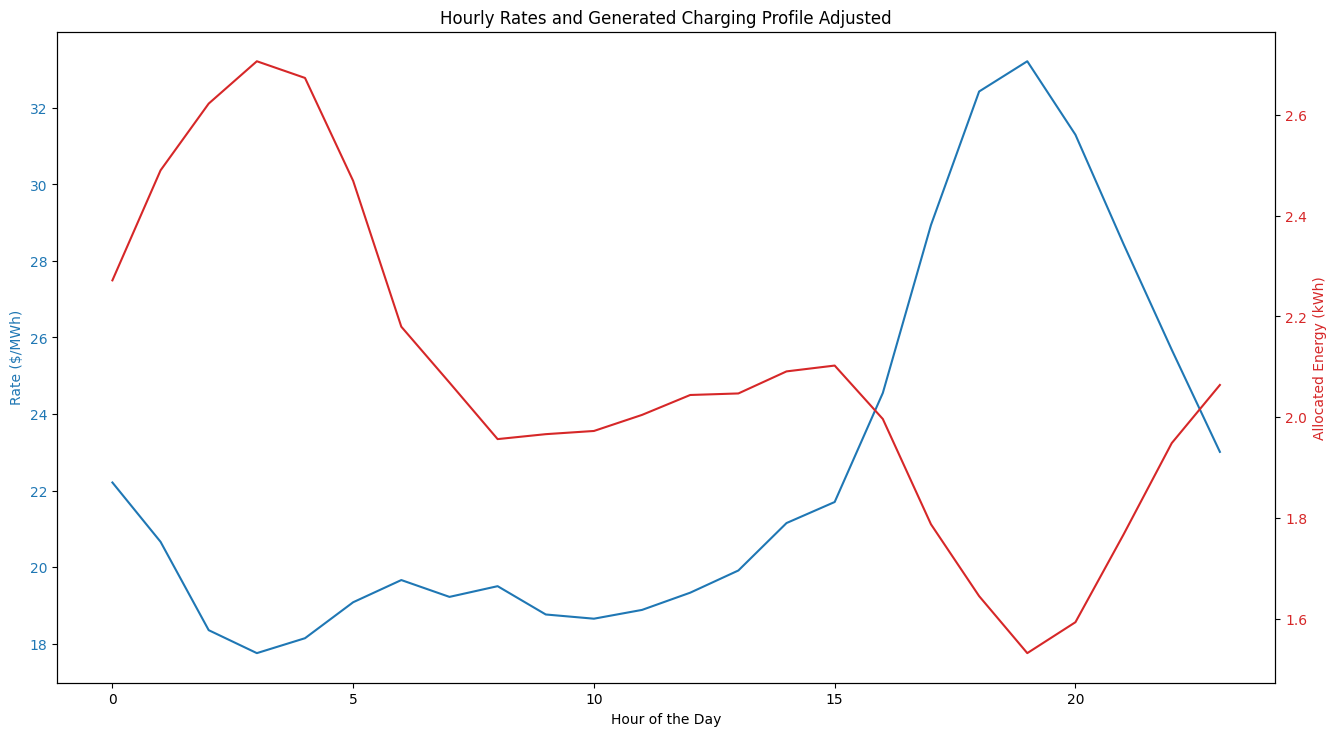

In [ ]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the hourly rates on the first axis
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Rate ($/MWh)', color='tab:blue')
ax1.plot(range(24), new_hourly_rates[0], color='tab:blue', label='Hourly Rates')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a twin Axes sharing the xaxis for the charging profile
ax2 = ax1.twinx()
ax2.set_ylabel('Allocated Energy (kWh)', color='tab:red')
ax2.plot(range(24), generated_profile_adjusted, color='tab:red', label='Generated Profile Adjusted')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a title and layout adjustments
ax1.set_title('Hourly Rates and Generated Charging Profile Adjusted')
fig.tight_layout(pad=3.0)

# Show the plot
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/energy_model/')